In [181]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [182]:
df=pd.read_csv('./HINDUNILVR.csv',index_col='Date',parse_dates=True)

Data Pre processing


In [183]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HINDLEVER,EQ,2136.60,2300.0,2307.55,2300.00,2307.55,2307.55,2307.08,24903,5.745330e+12,NaN,NaN,NaN
2000-01-04,HINDLEVER,EQ,2307.55,2381.0,2381.00,2250.00,2270.00,2281.05,2298.15,58514,1.344740e+13,NaN,NaN,NaN
2000-01-05,HINDLEVER,EQ,2281.05,2200.0,2250.00,2105.00,2183.50,2199.90,2211.17,80296,1.775482e+13,NaN,NaN,NaN
2000-01-06,HINDLEVER,EQ,2199.90,2224.9,2360.00,2210.00,2300.00,2288.20,2301.80,190032,4.374157e+13,NaN,NaN,NaN
2000-01-07,HINDLEVER,EQ,2288.20,2300.0,2452.00,2282.25,2395.00,2412.95,2380.24,192582,4.583919e+13,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HINDUNILVR,EQ,2307.75,2324.0,2369.80,2311.00,2367.70,2360.65,2340.89,1946867,4.557405e+14,85684.0,1289103.0,0.6621
2021-04-27,HINDUNILVR,EQ,2360.65,2363.0,2386.45,2352.95,2378.00,2379.85,2374.40,1668456,3.961583e+14,84641.0,1089882.0,0.6532
2021-04-28,HINDUNILVR,EQ,2379.85,2380.0,2445.00,2366.30,2404.00,2406.55,2414.15,1951215,4.710522e+14,84910.0,1024216.0,0.5249


In [184]:
df['Date']=df.index

In [185]:
start_date='2016-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [186]:
df=df.loc[mask]

In [187]:
df=df.loc[mask]

In [188]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [189]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [190]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [191]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [192]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (1187, 50) Y.shape (1187,)


In [193]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

ANN

In [194]:
i=Input(shape=(T,))
x=Dense(400,activation='relu')(i)
x=Dense(100,activation='relu')(x)
x=Dense(50,activation='relu')(x)
x=Dense(1,activation='relu')(x)
model_ann=Model(i,x)
model_ann.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 50)]              0         
                                                                 
 dense_33 (Dense)            (None, 400)               20400     
                                                                 
 dense_34 (Dense)            (None, 100)               40100     
                                                                 
 dense_35 (Dense)            (None, 50)                5050      
                                                                 
 dense_36 (Dense)            (None, 1)                 51        
                                                                 
Total params: 65,601
Trainable params: 65,601
Non-trainable params: 0
_________________________________________________________________


In [195]:
model_ann.compile(
    loss='mse',
    optimizer='adamax',
    metrics='mae'
)

In [196]:
r=model_ann.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
26/26 [==============================] - 1s 7ms/step - loss: 262.3058 - mae: 11.8744 - val_loss: 1602.9370 - val_mae: 25.6717
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 241.6690 - mae: 11.4115 - val_loss: 1619.1471 - val_mae: 25.9689
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 231.9581 - mae: 11.1542 - val_loss: 1618.9208 - val_mae: 26.0228
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 222.8150 - mae: 10.8876 - val_loss: 1635.9540 - val_mae: 26.2219
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217.6439 - mae: 10.7367 - val_loss: 1608.4712 - val_mae: 25.8833
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 212.0499 - mae: 10.5779 - val_loss: 1640.1631 - val_mae: 26.2452
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 205.9964 - mae: 10.3933 - val_loss: 1631.4464 - val_mae: 26.2131
Epoch 8/100
26/26 [===============

CNN

In [197]:
i=Input(shape=(T,1))
x=Conv1D(25,3,activation='relu')(i)
x=MaxPooling1D(2)(x)
x=Conv1D(50,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(1)(x)
model_cnn=Model(i,x)
model_cnn.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 48, 25)            100       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 24, 25)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 22, 50)            3800      
                                                                 
 global_max_pooling1d_9 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_37 (Dense)            (None, 1)                 51 

In [198]:
model_cnn.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [199]:
r=model_cnn.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
26/26 [==============================] - 1s 9ms/step - loss: 293.9577 - mae: 12.3498 - mse: 293.9577 - val_loss: 1702.1533 - val_mae: 26.1878 - val_mse: 1702.1533
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 260.6965 - mae: 11.7804 - mse: 260.6965 - val_loss: 1702.7616 - val_mae: 25.6805 - val_mse: 1702.7616
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 259.5590 - mae: 11.7676 - mse: 259.5590 - val_loss: 1697.3507 - val_mae: 25.9602 - val_mse: 1697.3507
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 257.1425 - mae: 11.7092 - mse: 257.1425 - val_loss: 1697.9819 - val_mae: 25.7788 - val_mse: 1697.9819
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 255.9964 - mae: 11.7125 - mse: 255.9964 - val_loss: 1698.6245 - val_mae: 25.7455 - val_mse: 1698.6245
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 256.0640 - mae: 11.7063 - mse: 256.0640 - val_loss: 

LSTM

In [200]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_lstm=Model(i,x)
model_lstm.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 50, 200)           161600    
                                                                 
 lstm_7 (LSTM)               (None, 50, 200)           320800    
                                                                 
 global_max_pooling1d_10 (Gl  (None, 200)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_38 (Dense)            (None, 100)               20100     
                                                                 
 dense_39 (Dense)            (None, 50)                5050      
                                                          

In [201]:
check_point_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [202]:
model_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [203]:
r=model_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm]
)

Epoch 1/100
26/26 [==============================] - 8s 202ms/step - loss: 262.1008 - mae: 11.8383 - mse: 262.1008 - val_loss: 1592.5985 - val_mae: 25.4912 - val_mse: 1592.5985
Epoch 2/100
26/26 [==============================] - 5s 177ms/step - loss: 260.9043 - mae: 11.7860 - mse: 260.9043 - val_loss: 1591.5004 - val_mae: 25.5352 - val_mse: 1591.5004
Epoch 3/100
26/26 [==============================] - 5s 174ms/step - loss: 260.4075 - mae: 11.7830 - mse: 260.4075 - val_loss: 1591.4357 - val_mae: 25.5582 - val_mse: 1591.4357
Epoch 4/100
26/26 [==============================] - 4s 171ms/step - loss: 260.0385 - mae: 11.7591 - mse: 260.0385 - val_loss: 1591.4384 - val_mae: 25.5315 - val_mse: 1591.4384
Epoch 5/100
26/26 [==============================] - 5s 175ms/step - loss: 259.9981 - mae: 11.7892 - mse: 259.9981 - val_loss: 1591.2273 - val_mae: 25.5361 - val_mse: 1591.2273
Epoch 6/100
26/26 [==============================] - 5s 182ms/step - loss: 260.3229 - mae: 11.7779 - mse: 260.3229 

GRU

In [204]:
i=Input(shape=(T,1))
x=GRU(200,return_sequences=True)(i)
x=GRU(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_gru=Model(i,x)
model_gru.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fe9871e2850>>

In [205]:
check_point_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [206]:
model_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [207]:
r=model_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_gru]
)

Epoch 1/100
26/26 [==============================] - 8s 179ms/step - loss: 265.2622 - mae: 11.9684 - mse: 265.2622 - val_loss: 1594.5061 - val_mae: 25.5032 - val_mse: 1594.5061
Epoch 2/100
26/26 [==============================] - 4s 153ms/step - loss: 261.5986 - mae: 11.8165 - mse: 261.5986 - val_loss: 1591.9755 - val_mae: 25.5190 - val_mse: 1591.9755
Epoch 3/100
26/26 [==============================] - 4s 151ms/step - loss: 261.1566 - mae: 11.7930 - mse: 261.1566 - val_loss: 1592.3678 - val_mae: 25.5823 - val_mse: 1592.3678
Epoch 4/100
26/26 [==============================] - 4s 150ms/step - loss: 260.0781 - mae: 11.7596 - mse: 260.0781 - val_loss: 1592.7776 - val_mae: 25.5838 - val_mse: 1592.7776
Epoch 5/100
26/26 [==============================] - 4s 152ms/step - loss: 259.8965 - mae: 11.7963 - mse: 259.8965 - val_loss: 1593.3441 - val_mae: 25.5223 - val_mse: 1593.3441
Epoch 6/100
26/26 [==============================] - 4s 150ms/step - loss: 261.1200 - mae: 11.7906 - mse: 261.1200 

Predictions

In [208]:
train_idx[:T+1]=False

In [209]:
Ptrain_ann=model_ann.predict(Xtrain).flatten()
Ptest_ann=model_ann.predict(Xtest).flatten()


In [210]:
Ptrain_cnn=model_cnn.predict(Xtrain).flatten()
Ptest_cnn=model_cnn.predict(Xtest).flatten()

In [211]:
Ptrain_lstm=model_lstm.predict(Xtrain).flatten()
Ptest_lstm=model_lstm.predict(Xtest).flatten()

In [212]:
Ptrain_gru=model_gru.predict(Xtrain).flatten()
Ptest_gru=model_gru.predict(Xtest).flatten()

In [213]:
df.loc[train_idx,'Diff ANN train prediction']=Ptrain_ann
df.loc[test_idx,'Diff ANN test prediction']=Ptest_ann

In [214]:
df.loc[train_idx,'Diff CNN train prediction']=Ptrain_cnn
df.loc[test_idx,'Diff CNN test prediction']=Ptest_cnn

In [215]:
df.loc[train_idx,'Diff LSTM train prediction']=Ptrain_lstm
df.loc[test_idx,'Diff LSTM test prediction']=Ptest_lstm

In [216]:
df.loc[train_idx,'Diff GRU train prediction']=Ptrain_gru
df.loc[test_idx,'Diff GRU test prediction']=Ptest_gru

In [217]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [218]:
last_train=train.iloc[-1]['Prev Close']

In [219]:
df.loc[train_idx,'train_ANN']=prev[train_idx]+Ptrain_ann
df.loc[test_idx,'Prediction_ANN']=prev[test_idx]+Ptest_ann

In [220]:
df.loc[train_idx,'train_CNN']=prev[train_idx]+Ptrain_cnn
df.loc[test_idx,'Prediction_CNN']=prev[test_idx]+Ptest_cnn

In [221]:
df.loc[train_idx,'train_LSTM']=prev[train_idx]+Ptrain_lstm
df.loc[test_idx,'Prediction_LSTM']=prev[test_idx]+Ptest_lstm

In [222]:
df.loc[train_idx,'train_GRU']=prev[train_idx]+Ptrain_gru
df.loc[test_idx,'Prediction_GRU']=prev[test_idx]+Ptest_gru

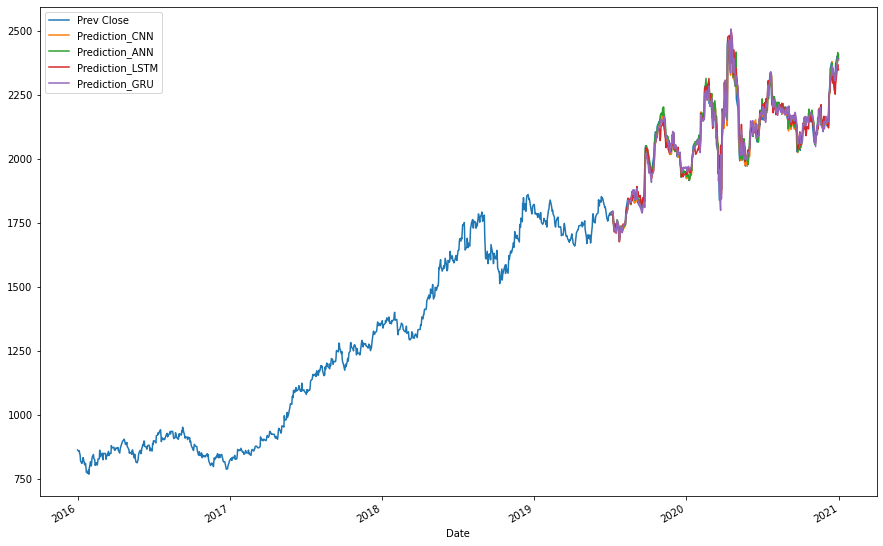

In [223]:
df[[ 'Prev Close','Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10));

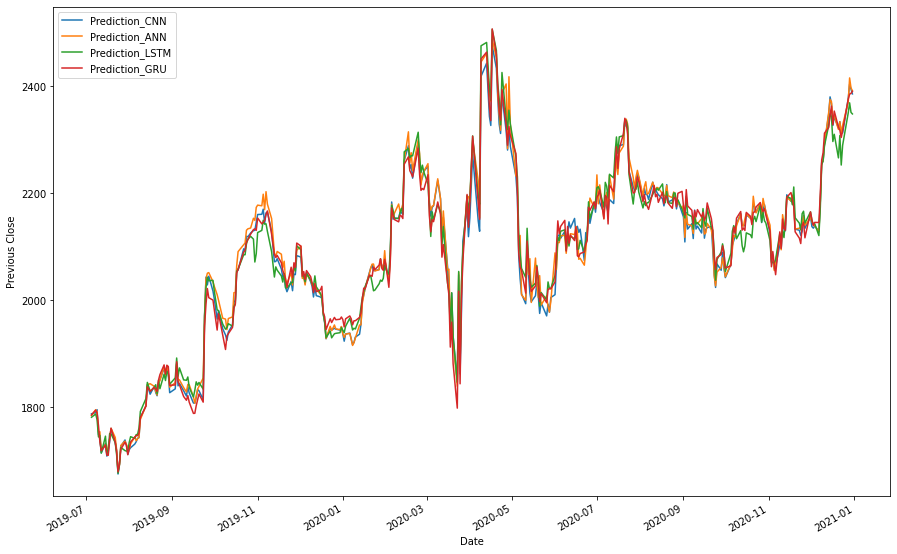

In [224]:
df[[ 'Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10),
    ylabel=("Previous Close"));

Evaluation

In [225]:
pred_ann=df['Prediction_ANN']
pred_ann.dropna(inplace=True)

In [226]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_ann))
print(rmse)

42.72693367442271


In [227]:
error=mean_absolute_error(test['Prev Close'],pred_ann)
print(error)

28.091621247616736


In [228]:
r2_score(test['Prev Close'],pred_ann)

0.9299291568533221

In [229]:
pred_cnn=df['Prediction_CNN']
pred_cnn.dropna(inplace=True)

In [230]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_cnn))
print(rmse)

41.30997784871594


In [231]:
error=mean_absolute_error(test['Prev Close'],pred_cnn)
print(error)

26.67693462474647


In [232]:
r2_score(test['Prev Close'],pred_cnn)

0.9344996207686905

In [233]:
pred_lstm=df['Prediction_LSTM']
pred_lstm.dropna(inplace=True)

In [234]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm))
print(rmse)

44.31782126276532


In [235]:
error=mean_absolute_error(test['Prev Close'],pred_lstm)
print(error)

31.077978826049627


In [236]:
r2_score(test['Prev Close'],pred_lstm)

0.9246140011569607

In [237]:
pred_gru=df['Prediction_GRU']
pred_gru.dropna(inplace=True)

In [238]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_gru))
print(rmse)

43.80592047103163


In [239]:
error=mean_absolute_error(test['Prev Close'],pred_gru)
print(error)

29.636172989906473


In [240]:
r2_score(test['Prev Close'],pred_gru)

0.9263454617850885